In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
# Import external libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# initialization
from objfun_node2vec import N2V
n2v = N2V('../data/clear_cluster_test/one_eighth.csv',
            '../data/clear_cluster_test/labels.csv')

TODO:
__Simulated annealing__ vs __Fast simulated annealing__

In [4]:
from heur_fsa import FastSimulatedAnnealing
from heur_aux import Correction, CauchyMutation

In [5]:
NUM_RUNS = 30 
maxeval = 30 

In [6]:
default_params=[1., 10, 80, 10]
opt_params=[2., 10, 100, 5] # known from the previous experiments optimal paremeters 

### Node2vec optimisation using FSA

In [7]:
def experiment_fsa(of, maxeval, num_runs, T0, n0, alpha, r, params):
    results = []
    for i in tqdm(range(num_runs), 'Testing T0={}, n0={}, alpha={}, r={}'.format(T0, n0, alpha, r)):
        mut = CauchyMutation(r=r, correction=Correction(of))
        result = FastSimulatedAnnealing(of, maxeval=maxeval, 
                                        T0=T0, n0=n0, alpha=alpha, 
                                        mutation=mut,params=params).search()
        result['run'] = i
        result['heur'] = 'FSA_{}_{}_{}_{}'.format(T0, n0, alpha, r) # name of the heuristic
        result['T0'] = T0
        result['n0'] = n0
        result['alpha'] = alpha
        result['r'] = r
        results.append(result)
    
    return pd.DataFrame(results, columns=['heur', 'run', 'T0', 'n0', 'alpha', 'r', 'best_x', 'best_y', 'neval'])

In [8]:
table_fsa = pd.DataFrame()

for T0 in [1e-10, 1e-2, 1, np.inf]: #[1e-10, 1e-2, 1, np.inf]
    res = experiment_fsa(of=n2v, maxeval=maxeval, num_runs=NUM_RUNS, 
                         T0=T0, n0=1, alpha=2, r=0.5,params=default_params)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [9]:
table_fsa.head()

heur  run            T0  n0  alpha    r  \
0  FSA_1e-10_1_2_0.5    0  1.000000e-10   1      2  0.5   
1  FSA_1e-10_1_2_0.5    1  1.000000e-10   1      2  0.5   
2  FSA_1e-10_1_2_0.5    2  1.000000e-10   1      2  0.5   
3  FSA_1e-10_1_2_0.5    3  1.000000e-10   1      2  0.5   
4  FSA_1e-10_1_2_0.5    4  1.000000e-10   1      2  0.5   

                                  best_x    best_y  neval  
0  [[1.30681997279817], 1.0, 10, 80, 10]  0.450382    inf  
1             [[0.125], 1.0, 10, 80, 10]  0.325581    inf  
2   [2.371030004186671, 1.0, 10, 80, 10]  0.436090    inf  
3  [1.7739501927747279, 1.0, 10, 80, 10]  0.503521    inf  
4  [2.7489267595790716, 1.0, 10, 80, 10]  0.511364    inf

In [10]:
def rel(x):
    return len([n for n in x if n < np.inf])/len(x)

def mne(x):
    return np.mean([n for n in x if n < np.inf])

def feo(x):
    return mne(x)/rel(x)

In [11]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0'],
    
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0'])

C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


heur            T0   feo  mne       rel
2  FSA_1e-10_1_2_0.5  1.000000e-10  30.0  1.0  0.033333
0   FSA_0.01_1_2_0.5  1.000000e-02   NaN  NaN  0.000000
1      FSA_1_1_2_0.5  1.000000e+00   NaN  NaN  0.000000
3    FSA_inf_1_2_0.5           inf  30.0  1.0  0.033333

__Since no solution were found in this experiment, I will try to use known optimal parameter values and run the experiment all over again.__ 

In [12]:
table_fsa_opt = pd.DataFrame()

for T0 in [1e-10, 1e-2, 1, np.inf]: #[1e-10, 1e-2, 1, np.inf]
    res = experiment_fsa(of=n2v, maxeval=maxeval, num_runs=NUM_RUNS, 
                         T0=T0, n0=1, alpha=2, r=0.5,params=opt_params)
    table_fsa_opt = pd.concat([table_fsa_opt, res], axis=0)

In [13]:
table_fsa_opt

heur  run            T0  n0  alpha    r  \
0   FSA_1e-10_1_2_0.5    0  1.000000e-10   1      2  0.5   
1   FSA_1e-10_1_2_0.5    1  1.000000e-10   1      2  0.5   
2   FSA_1e-10_1_2_0.5    2  1.000000e-10   1      2  0.5   
3   FSA_1e-10_1_2_0.5    3  1.000000e-10   1      2  0.5   
4   FSA_1e-10_1_2_0.5    4  1.000000e-10   1      2  0.5   
..                ...  ...           ...  ..    ...  ...   
25    FSA_inf_1_2_0.5   25           inf   1      2  0.5   
26    FSA_inf_1_2_0.5   26           inf   1      2  0.5   
27    FSA_inf_1_2_0.5   27           inf   1      2  0.5   
28    FSA_inf_1_2_0.5   28           inf   1      2  0.5   
29    FSA_inf_1_2_0.5   29           inf   1      2  0.5   

                                    best_x    best_y  neval  
0   [0.48418203241992375, 2.0, 10, 100, 5]  0.892857    inf  
1     [2.655219693445878, 2.0, 10, 100, 5]  0.892857    inf  
2    [0.2200696684370258, 2.0, 10, 100, 5]  1.000000    1.0  
3    [0.2401977038190224, 2.0, 10, 100, 5]  0.892857    inf  
4     [2.341679237077074, 2.0, 10, 100, 5]  1.000000    1.0  
..                                     ...       ...    ...  
25    [2.894544997461433, 2.0, 10, 100, 5]  0.892857    inf  
26  [0.33694011316904326, 2.0, 10, 100, 5]  1.000000    1.0  
27   [1.9340535344522802, 2.0, 10, 100, 5]  1.000000    1.0  
28   [0.8656884909771292, 2.0, 10, 100, 5]  0.892857    inf  
29    [3.845732014428546, 2.0, 10, 100, 5]  0.892857    inf  

[120 rows x 9 columns]

In [14]:
stats_fsa = table_fsa_opt.pivot_table(
    index=['heur', 'T0'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0'])

heur            T0       feo  mne       rel
2  FSA_1e-10_1_2_0.5  1.000000e-10  2.727273  1.0  0.366667
0   FSA_0.01_1_2_0.5  1.000000e-02  2.142857  1.0  0.466667
1      FSA_1_1_2_0.5  1.000000e+00  2.307692  1.0  0.433333
3    FSA_inf_1_2_0.5           inf  1.764706  1.0  0.566667

## Analysis

### Can we improve the best configuration ($T_0=1e-2$)?

In [16]:
# maxeval 1000
heur = FastSimulatedAnnealing(n2v, maxeval=300, T0=1e-2, n0=1, alpha=2, 
                              mutation=CauchyMutation(r=0.5, correction=Correction(n2v)),
                             params=opt_params)
result = heur.search()
print('neval = {}'.format(result['neval']))
print('best_x = {}'.format(result['best_x']))
print('best_y = {}'.format(result['best_y']))

neval = inf
best_x = [2.47042751886077, 2.0, 10, 100, 5]
best_y = 0.8928571428571429


In [17]:
log_data = result['log_data'].copy()
log_data = log_data[['step', 'x', 'f_x', 'y', 'f_y', 'T', 'swap']]  # column re-ordering, for better readability
log_data.head(10)

step                     x       f_x                     y       f_y  \
0     0               2.47043  0.892857               [0.125]  0.377778   
1     1               [0.125]  0.377778               [0.125]  0.377778   
2     2               [0.125]  0.377778               [0.125]  0.377778   
3     3               [0.125]  0.377778  [0.8623630430072184]  0.196078   
4     4  [0.8623630430072184]  0.196078  [0.8642313570910058]  0.196078   
5     5  [0.8642313570910058]  0.196078  [1.2703136351558584]  0.196078   
6     6  [1.2703136351558584]  0.196078  [1.5610515467165835]  0.240132   
7     7  [1.2703136351558584]  0.196078   [1.692130961281296]  0.176471   
8     8   [1.692130961281296]  0.176471   [2.148441498664122]  0.161184   
9     9   [2.148441498664122]  0.161184  [2.4592608933567086]  0.094340   

          T   swap  
0  0.010000   True  
1  0.005000   True  
2  0.002000   True  
3  0.001000   True  
4  0.000588   True  
5  0.000385   True  
6  0.000270  False  
7  0.000200   True  
8  0.000154   True  
9  0.000122   True

In [18]:
def plot_compare(step_data, ax1_col, ax1_label, ax2_col, ax2_label):
    fig, ax1 = plt.subplots()

    k = step_data.index.values
    T = step_data[ax1_col]
    ax1.plot(k, T, 'b-')
    ax1.set_xlabel('Step')
    ax1.set_ylabel(ax1_label, color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')

    ax2 = ax1.twinx()
    s2 = step_data[ax2_col]
    ax2.plot(k, s2, 'r.')
    ax2.set_ylabel(ax2_label, color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')

    plt.show()

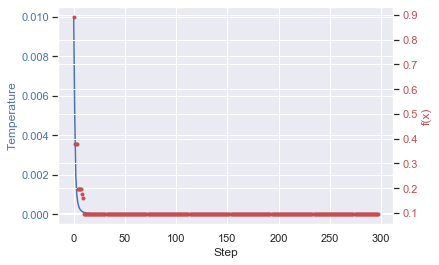

In [19]:
plot_compare(log_data, 'T', 'Temperature', 'f_x', 'f(x)')

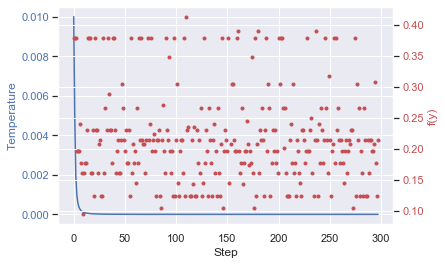

In [20]:
plot_compare(log_data, 'T', 'Temperature', 'f_y', 'f(y)')

### Slower cooling?
Let's double $n_0$:

In [21]:
# maxeval=1000
heur = FastSimulatedAnnealing(n2v, maxeval=maxeval, T0=1e-2, n0=2, alpha=2, 
                              mutation=CauchyMutation(r=0.5, correction=Correction(n2v)),
                             params=opt_params)
result = heur.search()
print('neval = {}'.format(result['neval']))
print('best_x = {}'.format(result['best_x']))
print('best_y = {}'.format(result['best_y']))

neval = inf
best_x = [0.9811423324915154, 2.0, 10, 100, 5]
best_y = 0.8928571428571429


In [22]:
log_data = result['log_data'].copy()
log_data = log_data[['step', 'x', 'f_x', 'y', 'f_y', 'T', 'swap']]  
# column re-ordering, for better readability

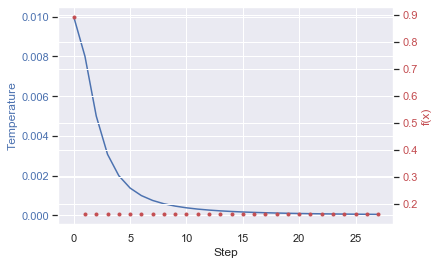

In [23]:
plot_compare(log_data, 'T', 'Temperature', 'f_x', 'f(x)')

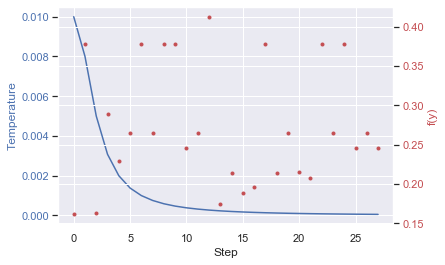

In [24]:
plot_compare(log_data, 'T', 'Temperature', 'f_y', 'f(y)')

__More thorough testing:__

In [25]:
# cooling strategy parameter testing
for n0 in [2, 3, 5, 10]:
    res = experiment_fsa(of=n2v, maxeval=maxeval, num_runs=NUM_RUNS, T0=1e-2, n0=n0, alpha=2, r=0.5,
                        params=opt_params)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [26]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0', 'n0'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0', 'n0'])

C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


heur            T0  n0        feo  mne       rel
6  FSA_1e-10_1_2_0.5  1.000000e-10   1  30.000000  1.0  0.033333
1   FSA_0.01_1_2_0.5  1.000000e-02   1        NaN  NaN  0.000000
2   FSA_0.01_2_2_0.5  1.000000e-02   2   2.142857  1.0  0.466667
3   FSA_0.01_3_2_0.5  1.000000e-02   3   2.500000  1.0  0.400000
4   FSA_0.01_5_2_0.5  1.000000e-02   5   2.142857  1.0  0.466667
0  FSA_0.01_10_2_0.5  1.000000e-02  10   2.500000  1.0  0.400000
5      FSA_1_1_2_0.5  1.000000e+00   1        NaN  NaN  0.000000
7    FSA_inf_1_2_0.5           inf   1  30.000000  1.0  0.033333

__Is the mutation $r$ adequate?__

In [27]:
log_data['jump_length'] = log_data.apply(lambda r: np.linalg.norm(r['x'] - r['y']), axis=1)
log_data.head(10)

step                    x       f_x                      y       f_y  \
0     0             0.981142  0.892857    [0.560167100291652]  0.161491   
1     1  [0.560167100291652]  0.161491                [0.125]  0.377778   
2     2  [0.560167100291652]  0.161491   [0.5411875824937457]  0.163636   
3     3  [0.560167100291652]  0.161491   [0.4142949072092533]  0.288889   
4     4  [0.560167100291652]  0.161491   [1.4815349284397192]  0.229452   
5     5  [0.560167100291652]  0.161491  [0.47048847392484777]  0.265306   
6     6  [0.560167100291652]  0.161491                [0.125]  0.377778   
7     7  [0.560167100291652]  0.161491   [0.3195138665175824]  0.265306   
8     8  [0.560167100291652]  0.161491                [0.125]  0.377778   
9     9  [0.560167100291652]  0.161491                [0.125]  0.377778   

          T   swap  jump_length  
0  0.010000   True     0.420975  
1  0.008000  False     0.435167  
2  0.005000  False     0.018980  
3  0.003077  False     0.145872  
4  0.002000  False     0.921368  
5  0.001379  False     0.089679  
6  0.001000  False     0.435167  
7  0.000755  False     0.240653  
8  0.000588  False     0.435167  
9  0.000471  False     0.435167

In [28]:
log_data['jump_length'].describe()

count    28.000000
mean      0.568641
std       0.885719
min       0.015450
25%       0.131992
50%       0.349214
75%       0.435167
max       3.564833
Name: jump_length, dtype: float64

In [29]:
for r in [.1, .25, .75, 1, 2]:
    res = experiment_fsa(of=n2v, maxeval=maxeval, num_runs=NUM_RUNS, T0=1e-2, n0=5, alpha=2, r=r,
                        params=opt_params)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [30]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0', 'n0', 'r'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0', 'n0', 'r'])

C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


heur            T0  n0     r        feo  mne       rel
11  FSA_1e-10_1_2_0.5  1.000000e-10   1  0.50  30.000000  1.0  0.033333
1    FSA_0.01_1_2_0.5  1.000000e-02   1  0.50        NaN  NaN  0.000000
2    FSA_0.01_2_2_0.5  1.000000e-02   2  0.50   2.142857  1.0  0.466667
3    FSA_0.01_3_2_0.5  1.000000e-02   3  0.50   2.500000  1.0  0.400000
4    FSA_0.01_5_2_0.1  1.000000e-02   5  0.10   1.875000  1.0  0.533333
5   FSA_0.01_5_2_0.25  1.000000e-02   5  0.25   3.750000  1.0  0.266667
6    FSA_0.01_5_2_0.5  1.000000e-02   5  0.50   2.142857  1.0  0.466667
7   FSA_0.01_5_2_0.75  1.000000e-02   5  0.75   2.727273  1.0  0.366667
8      FSA_0.01_5_2_1  1.000000e-02   5  1.00   2.727273  1.0  0.366667
9      FSA_0.01_5_2_2  1.000000e-02   5  2.00   1.875000  1.0  0.533333
0   FSA_0.01_10_2_0.5  1.000000e-02  10  0.50   2.500000  1.0  0.400000
10      FSA_1_1_2_0.5  1.000000e+00   1  0.50        NaN  NaN  0.000000
12    FSA_inf_1_2_0.5           inf   1  0.50  30.000000  1.0  0.033333

The best performing instance of FSA, according to $FEO$:

In [32]:
stats_fsa.sort_values(by=['feo']).head(3)

heur    T0  n0    r       feo  mne       rel
4  FSA_0.01_5_2_0.1  0.01   5  0.1  1.875000  1.0  0.533333
9    FSA_0.01_5_2_2  0.01   5  2.0  1.875000  1.0  0.533333
2  FSA_0.01_2_2_0.5  0.01   2  0.5  2.142857  1.0  0.466667

## Conclusion